In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
from sklearn import model_selection,decomposition, linear_model,ensemble, neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from skimage.transform import rescale
from scipy import ndimage as ndi

matplotlib.style.use('fivethirtyeight')



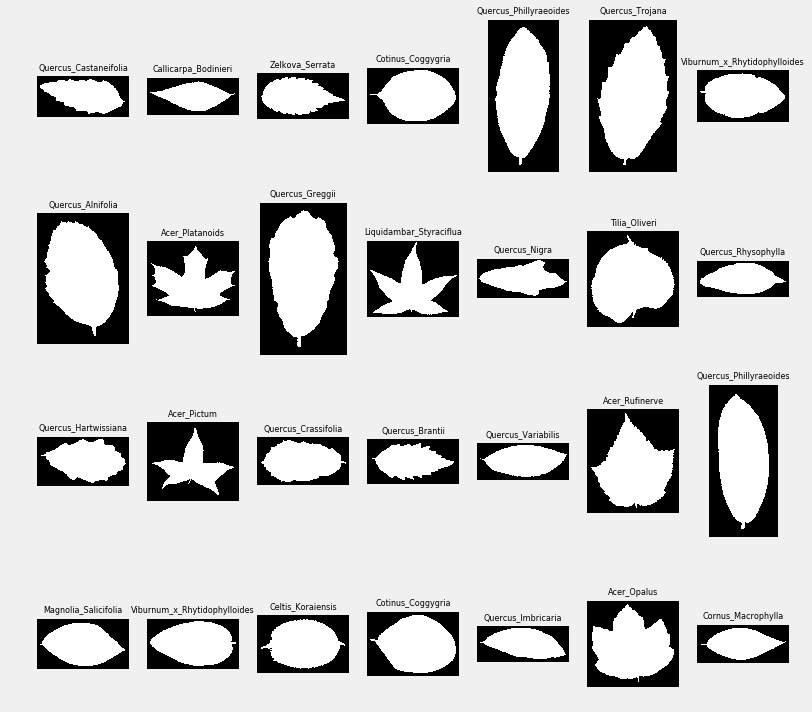

In [4]:
#load data
dataDir='./leaf-classification/'
trainData = pd. read_csv(dataDir+'train.csv')
classEncoder = LabelEncoder()
trainLabels = classEncoder.fit_transform(trainData.loc[:,'species'])
trainIDs = np.array(trainData.loc[:,'id'])


#random images
plt.figure(figsize=(12,12))
for k in range(28):
    randTrainInd = np.random.randint(len(trainIDs))
    randomID = trainIDs[randTrainInd]
    imageFilename = dataDir+'images/'+str(randomID)+'.jpg'
    plt.subplot(4,7,k+1) 
    plt.imshow(mpimg.imread(imageFilename), cmap='gray')
    plt.title(classEncoder.classes_[trainLabels[randTrainInd]],fontsize=8)
    plt.axis('off')

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


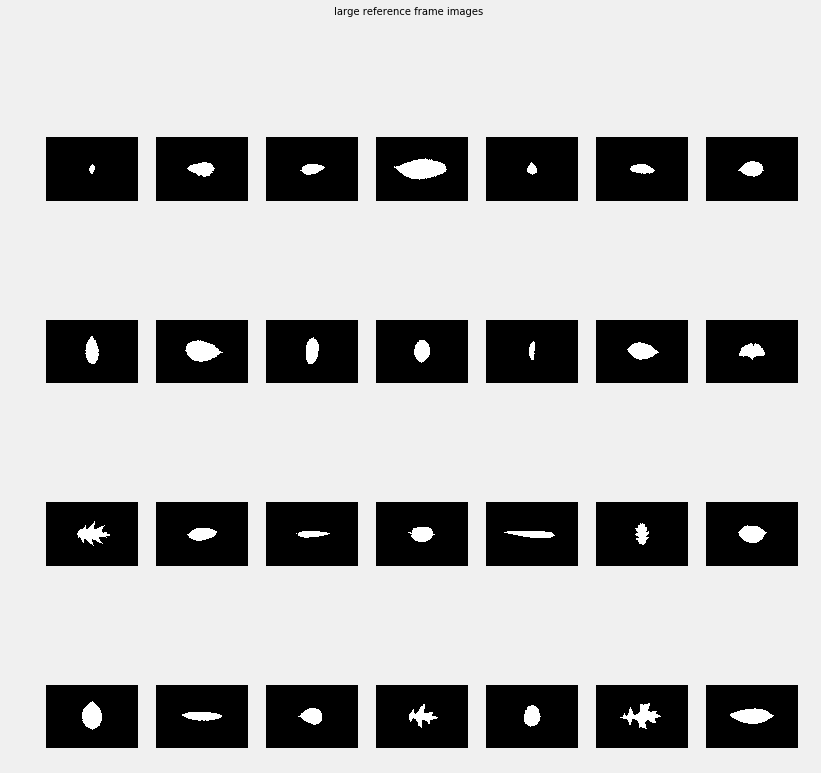

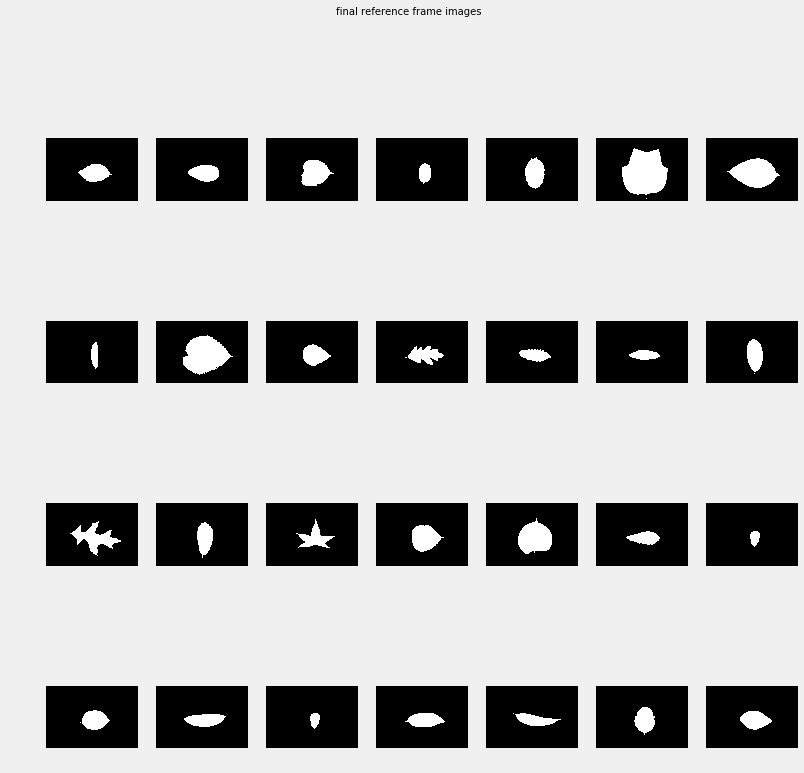

In [5]:
#preprocess images
numImages = 1584
shapesMatrix = np.zeros((2,numImages))
listOfImages =[]
for k in range(numImages):
        imageFilename = dataDir+'images/'+str(k+1)+'.jpg'
        currImage = mpimg.imread(imageFilename)
        shapesMatrix[:,k]=np.shape(currImage)
        listOfImages.append(currImage)
        
        
#create large 3d matrix with all images
maxShapeSize = shapesMatrix.max(axis=1)

for k in range(len(maxShapeSize)):
    if maxShapeSize[k]%2 ==0:
        maxShapeSize[k]+=311
    else:
        maxShapeSize[k]+=310
        
fullImageMatrix3D = np.zeros(np.hstack((maxShapeSize,
                                       np.shape(shapesMatrix[1]))).astype(int),dtype=np.dtype('u1'))
destXc=(maxShapeSize[1]+1)/2; destYc = (maxShapeSize[0]+1)/2

for k, currImage in enumerate(listOfImages):
    Yc, Xc = ndi.center_of_mass(currImage)
    Xd = destXc - Xc; Yd =  destYc -Yc
    rowIndLims = (int(round(Yd)),int(round(Yd)+np.shape(currImage)[0]))
    colIndLims = (int(round(Xd)),int(round(Xd)+np.shape(currImage)[1]))
    fullImageMatrix3D[rowIndLims[0]:rowIndLims[1],colIndLims[0]:colIndLims[1],k] = currImage
    
    
plt.figure(figsize=(12,12))
plt.suptitle('large reference frame images', fontsize=10)
for k in range(28):
    randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4,7,k+1); plt.imshow(fullImageMatrix3D[:,:,randInd],cmap='gray');plt.axis('off')
    
    
#remove redundant rows and columns
xValid=fullImageMatrix3D.mean(axis=2).sum(axis=0)>0
yValid=fullImageMatrix3D.mean(axis=2).sum(axis=1)>0
xLims =(np.nonzero(xValid)[0][0], np.nonzero(xValid)[0][-1])
yLims = (np.nonzero(yValid)[0][0],np.nonzero(yValid)[0][-1])

fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1],xLims[0]:xLims[1],:]

plt.figure(figsize=(12,12))
plt.suptitle('final reference frame images',fontsize=10)

for k in range(28):
    randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4,7,k+1); plt.imshow(fullImageMatrix3D[:,:,randInd],cmap='gray');plt.axis('off')
    
    
rescaleFactor = 0.15
scaleDownImage = rescale(fullImageMatrix3D[:,:,0],rescaleFactor)
scaleDownImages = np.zeros(np.hstack((np.shape(scaleDownImage),
                                    np.shape(fullImageMatrix3D)[2])), dtype=np.dtype('f4'))

for imInd in range(np.shape(fullImageMatrix3D)[2]):
    scaleDownImages[:,:,imInd] = rescale(fullImageMatrix3D[:,:,imInd],rescaleFactor)
    
del fullImageMatrix3D
    

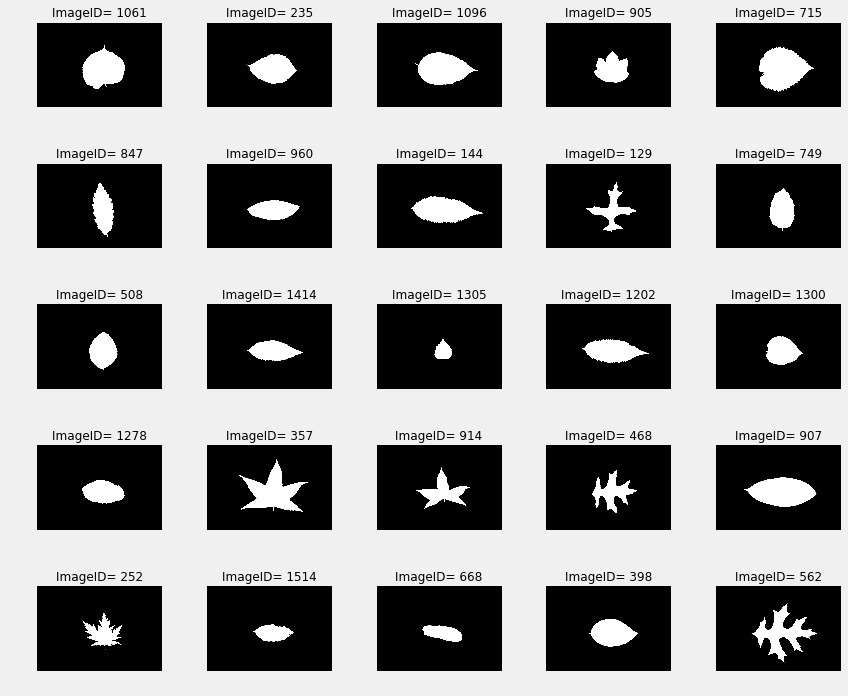

In [6]:
np.random.seed(1)

plt.figure(figsize=(12,10))
for k in range(25):
    randInd = np.random.randint(np.shape(scaleDownImages)[2])
    plt.subplot(5,5,k+1)
    plt.imshow(scaleDownImages[:,:,randInd], cmap='gray')
    plt.axis('off');plt.title('ImageID= '+str(randInd),fontsize=12)
    
plt.tight_layout()